Some of the code in this lab was copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# Comparing Machine Learning Techniques Using Pipelines - Lab

## Introduction

In this lab, you'lll use a Dataset created by Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

The description of the data set is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to our product line.

A consistent analysis of the performance of our products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of our product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights Otto Group can generate about their product range.

In this lab, you'll use a data set containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product


## Objectives

You will be able to:
- Compare different classification techniques
- Construct pipelines in scikit-learn
- Use pipelines in combination with GridSearchCV

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. create a baseline model
4. create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

The data is stored in "otto_group.csv".

Things to do here:
- Check for NAs
- Check the distributions
- Check how many inputs there are
- ...

In [1]:
# create dataframe
import pandas as pd

df = pd.read_csv("otto_group.csv")
df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [2]:
# check for NaNs
nan_cols = []
for col in df.columns:
    if df[col].isna().sum() > 0:
        nan_cols.append(col)
len(nan_cols)

0

In [3]:
# Check the distributions of the features
import scipy.stats as stats

# I will run ks-tests with an alpha of 0.05 to see if the distributions are normal
def count_norm_cols(df):
    normal_cols = []
    for col in df.columns[:-1]:
        statistic, p_value = stats.kstest(df[col], "norm", args=(df[col].mean(), df[col].std()))
        if p_value > 0.05:
            normal_cols.append(col)
    print("Amount of columns that are normally distributed:", len(normal_cols))
    
count_norm_cols(df)

Amount of columns that are normally distributed: 0


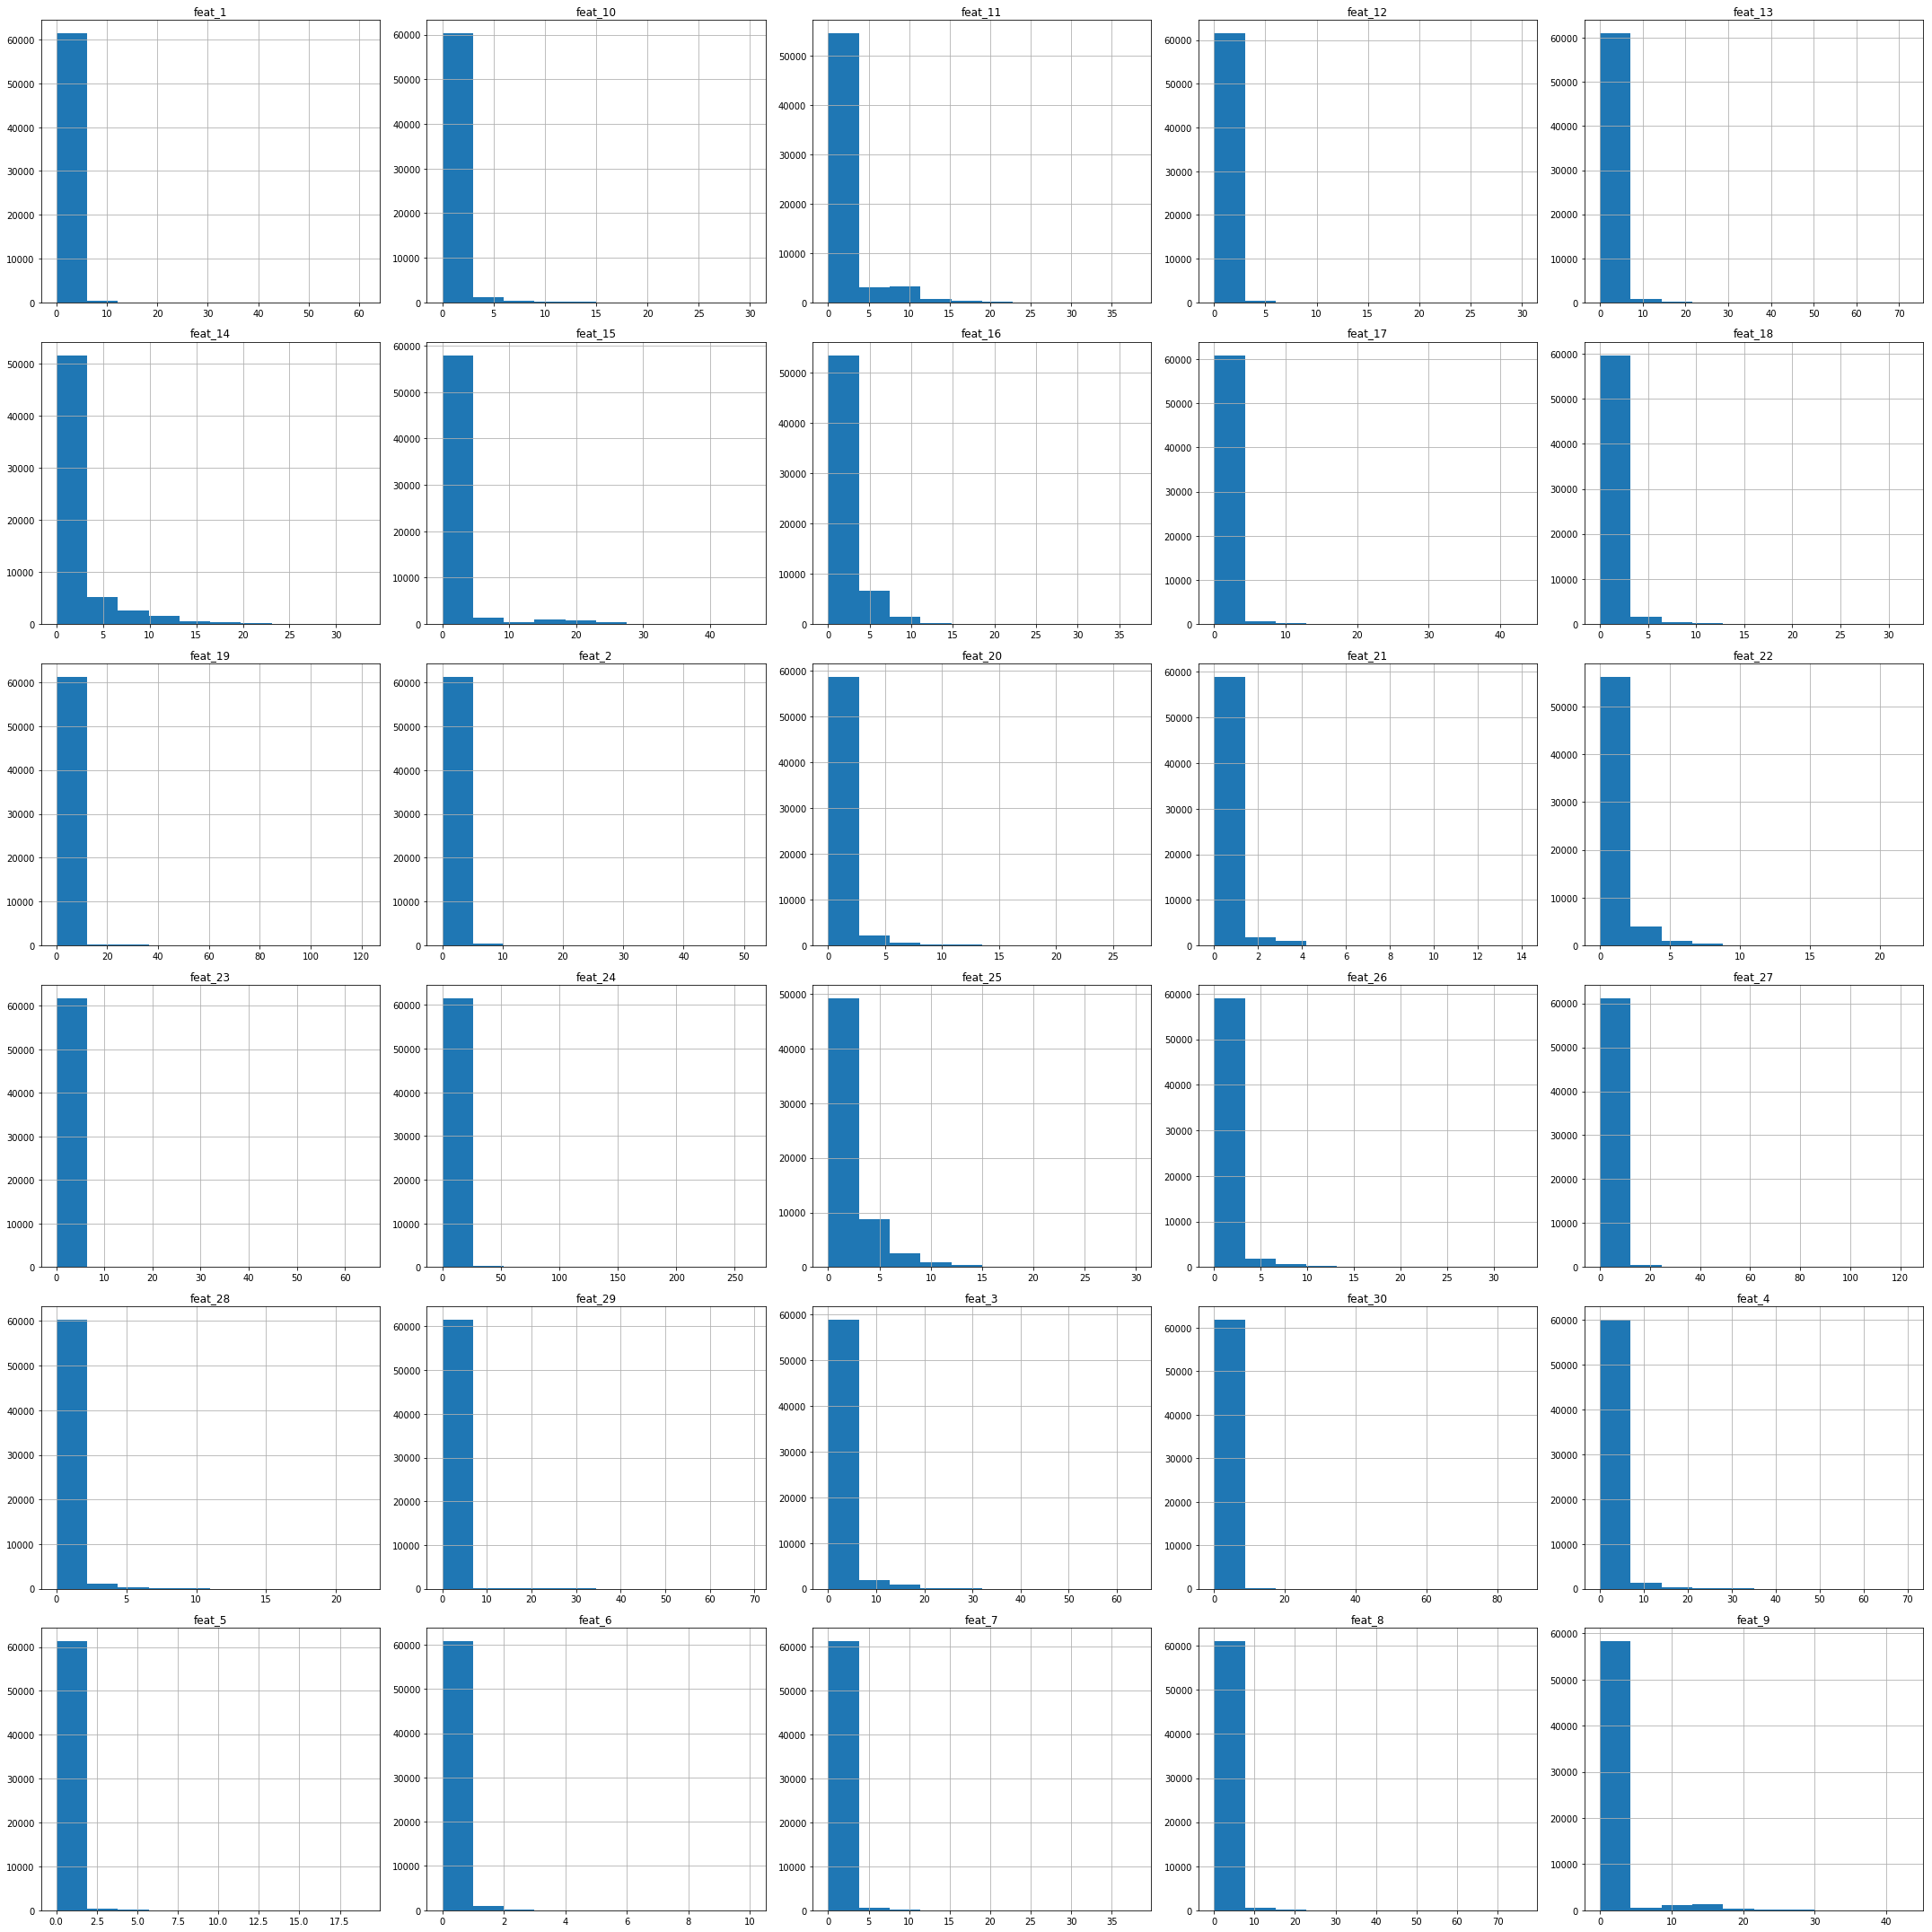

In [4]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# create histograms to visualize features
import matplotlib.pyplot as plt
%matplotlib inline

feat = df.loc[:, 'feat_1':'feat_30']
feat.hist(figsize=(30, 30))
plt.tight_layout()
plt.show()

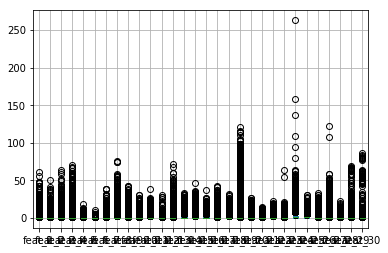

In [5]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# visualize boxplots
feat = df.loc[:, 'feat_1':'feat_30']
feat.boxplot();

In [6]:
# check to see if any features are only zeros
cols_to_drop = []
for col in df.columns:
    all_zeros = True
    for value in df[col]:
        if value != 0:
            all_zeros = False
    if all_zeros == True:
        cols_to_drop.append(col)
print(cols_to_drop)

[]


If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

Because the data is zero-inflated the boxplots look as shown above. Because there are this many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. More-over, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

## Feature engineering and selection with PCA

In [7]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# set X and y
X = df.loc[:, 'feat_1':'feat_93']
y = df.target

Have a look at the correlation structure of your features using a heatmap.

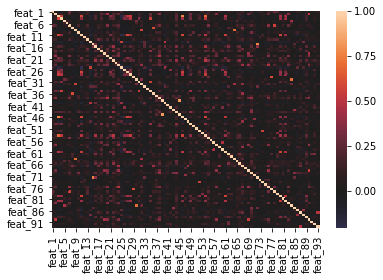

In [8]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution
# heatmap
import seaborn as sns

sns.heatmap(X.corr(), center=0)

Use PCA to downscale your features. Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [9]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution
from sklearn.decomposition import PCA
import numpy as np

# PCA
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

for pca in [pca_1, pca_2, pca_3]:
    pca.fit(X)
    print(np.sum(pca.explained_variance_ratio_))
    
pca = PCA(n_components=27)
X_pca = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))

0.7275417066360486
0.8886322227765069
0.9597922580526078
0.8003326119301182


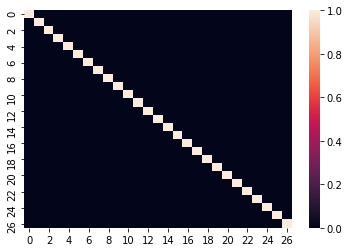

In [10]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

sns.heatmap(pd.DataFrame(X_pca).corr());

## Create a train test split with a test size of 40%

This is a relatively big training set. Feel free to make it smaller (down to ~20%), but for an initial run you can try smaller training sets so the computation time is more manageable.

For now, simply use the original data and not the principal components. We looked at the PC's first to get a sense of our correlation structure, and to see how we can downsize our data without losing too much information. In what's next, you'll make PCA part of the pipeline!!

In [11]:
# Your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline
- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be the building a basic logistic regression model.

Make sure to fit the model using the training set, and test the result by obtaining the accuracy using the test set.

In [12]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# contsruct pipeline
pipe_lr = Pipeline([
    ('pca', PCA(n_components=27, random_state=123)),
    ('clf', LogisticRegression(random_state=123))
     ])

# fit pipeline
pipe_lr.fit(X_train, y_train)

print(accuracy_score(y_test, pipe_lr.predict(X_test)))

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7152149321266968


## Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SCM
- One for a default decision tree
- One for a RandomForestClassifier

In [13]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# ⏰ This cell may take several minutes to run

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# construct pipelines

pipe_svm = Pipeline([('pca', PCA(n_components=27)),
                     ('clf', svm.SVC(random_state=123))
                        ])

pipe_tree = Pipeline([('pca', PCA(n_components=27)),
                     ('clf', tree.DecisionTreeClassifier(random_state=123))
                        ])

pipe_rf = Pipeline([('pca', PCA(n_components=27)),
                     ('clf', RandomForestClassifier(random_state=123))
                        ])

# list of pipelines list of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine', 'Decision Tree', 'Random Forest']

# fit pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    
# compare accuracies
for index, val in enumerate(pipelines):
    print("{} Pipeline accuracy {}".format(pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=27,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=123, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=27,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto',

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Support Vector Machine Pipeline accuracy 0.7430510665804784
Decision Tree Pipeline accuracy 0.6634615384615384
Random Forest Pipeline accuracy 0.7399402068519716


## Pipeline with grid search

Construct two pipelines with grid search:
- one for random forests - try to have around 40 different models
- one for the adaboost algorithm 

As extra, level-up work, construct a pipeline with grid search for support vector machines. 
* Make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!

### Random Forest pipeline with grid search

In [14]:
# Your code here 
# imports
from sklearn.model_selection import GridSearchCV

In [15]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# ⏰ This cell may take a long time to run!

# construct pipeline
pipe_rf = Pipeline([
    ('pca', PCA(n_components=27)),
    ('clf', RandomForestClassifier(random_state=123))
])


# set grid search paramas
param_grid_forest = [{
    'clf__n_estimators' : [120],
    'clf__criterion' : ['entropy', 'gini'],
    'clf__max_depth' : [4,5,6],
    'clf__min_samples_leaf' : [0.05, 0.1, 0.2],
    'clf__min_samples_split' : [0.05, 0.1, 0.2]
}]

# construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=param_grid_forest,
                     scoring = 'accuracy',
                     cv=3, verbose=2, return_train_score=True)

# fit grid search
gs_rf.fit(X_train, y_train)

# best accuracy
print('best accuracy: {}'.format(gs_rf.best_score_))
# best params
print('best params: {}'.format(gs_rf.best_params_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   8.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   8.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   8.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   8.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   8.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   9.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   7.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   8.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   7.8s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   5.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   5.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   5.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   5.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samp

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.8s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   1.9s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   1.9s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sam

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   1.9s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   1.8s


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 12.2min finished


best accuracy: 0.6240639982761407
best params: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}


Use your grid search object along with `.cv_results` to get the full result overview

In [16]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

gs_rf.cv_results_

{'mean_fit_time': array([8.57675878, 8.57243156, 7.59167719, 5.49428058, 5.50028968,
        5.50560514, 2.56114658, 2.54618923, 2.56282457, 8.97796647,
        8.96932832, 7.69175116, 5.49530021, 5.50692757, 5.49596659,
        2.5491821 , 2.53322244, 2.55648677, 9.13722897, 9.0920186 ,
        7.72931019, 5.49796311, 5.49196863, 5.4856499 , 2.5531528 ,
        2.558477  , 2.55947669, 3.55515877, 3.57941826, 3.13286146,
        2.80980086, 2.75728782, 2.73899881, 1.71244121, 1.72372373,
        1.70609951, 3.77422627, 3.81809362, 3.18181992, 2.81647952,
        2.73633305, 2.76095303, 1.74101289, 1.72803553, 1.70941591,
        3.90355953, 3.8756365 , 3.20440332, 2.73436197, 2.75263826,
        2.75165574, 1.71870732, 1.69680421, 1.72969619]),
 'std_fit_time': array([0.08932101, 0.06271036, 0.15515192, 0.07013027, 0.11061559,
        0.13690074, 0.02975344, 0.01623948, 0.03372142, 0.13400176,
        0.11534859, 0.19799024, 0.06004332, 0.1182196 , 0.11691667,
        0.03223904, 0.042

### Adaboost

In [17]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution

# ⏰ This cell may take several minutes to run
from sklearn.ensemble import AdaBoostClassifier

# construct pipeline
pipe_ab = Pipeline([
    ('pca', PCA(n_components=27)),
    ('clf', AdaBoostClassifier(random_state=123))
])

# param grid
adaboost_param_grid = {
    'clf__n_estimators' : [30, 50, 70],
    'clf__learning_rate' : [1, 0.5, 0.1]
}

# construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
                    param_grid=adaboost_param_grid,
                    scoring='accuracy',
                    cv=3, verbose=2, return_train_score=True)

# fit using grid search
gs_ab.fit(X_train, y_train)


# best accuracy
print('best accuracy: {}'.format(gs_ab.best_score_))
# best params
print('best params: {}'.format(gs_ab.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   3.7s
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   3.7s
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   3.7s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   5.9s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   6.1s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   6.1s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=70, total=   8.2s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=70, total=   8.4s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.9min finished


best accuracy: 0.6613424554220761
best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 70}


Use your grid search object along with `.cv_results` to get the full result overview

In [18]:
# this cell of code copied from the solution at https://github.com/learn-co-curriculum/dsc-pipelines-lab/tree/solution
gs_ab.cv_results_

{'mean_fit_time': array([3.58743191, 5.86496798, 8.10332584, 3.62131206, 5.83238689,
        8.2755549 , 3.91916243, 5.81111375, 8.33669647]),
 'std_fit_time': array([0.01197755, 0.07623676, 0.10106649, 0.08338488, 0.02238668,
        0.09892092, 0.41216688, 0.01386272, 0.17542081]),
 'mean_score_time': array([0.10202241, 0.15622568, 0.21008213, 0.09871276, 0.15156881,
        0.20608322, 0.09772515, 0.15856496, 0.19678402]),
 'std_score_time': array([0.00692619, 0.01802656, 0.011117  , 0.00858005, 0.01075764,
        0.00600356, 0.00710993, 0.00615015, 0.00599085]),
 'param_clf__learning_rate': masked_array(data=[1, 1, 1, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_clf__n_estimators': masked_array(data=[30, 50, 70, 30, 50, 70, 30, 50, 70],
              mask=[False, False, False, False, False, False, False, False,
                    Fa

### Level-up: SVM pipeline with grid search

In [19]:
# ⏰ This cell may take a very long time to run!



Use your grid search object along with `.cv_results` to get the full result overview

In [20]:
# Your code here 

## Note

Note that this solution is only one of many options. The results in the Random Forest and Adaboost models show that there is a lot of improvement possible tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You now got a lot of practice in. What algorithm would you choose and why?

In [22]:
# I would choose the support vector machine pipeline because it had better accuracy